<a href="https://colab.research.google.com/github/soham7707/Portfolio_Agents/blob/main/Level_2_Beta_GARCH_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance arch statsmodels matplotlib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 15.3 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Calculated Beta: 1.2618


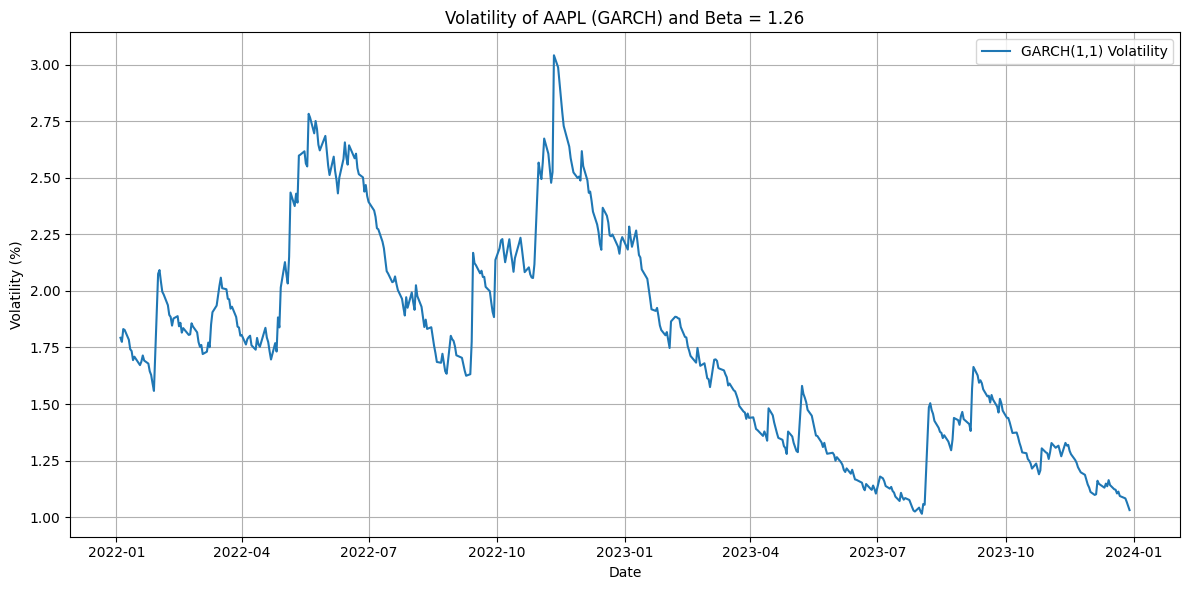

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm

# Step 1: Download data
stock = 'AAPL'           # Replace with your desired stock
market_index = '^GSPC'   # S&P 500 as market proxy

start_date = '2022-01-01'
end_date = '2024-01-01'

# Step 1: Download data (FIXED)
stock_data = yf.download(stock, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
market_data = yf.download(market_index, start=start_date, end=end_date, auto_adjust=False)['Adj Close']


# Step 2: Calculate log returns
stock_returns = np.log(stock_data / stock_data.shift(1)).dropna()
market_returns = np.log(market_data / market_data.shift(1)).dropna()

# Align lengths
returns = pd.concat([stock_returns, market_returns], axis=1).dropna()
returns.columns = ['Stock', 'Market']

# Step 3: Compute Beta via linear regression
X = sm.add_constant(returns['Market'])
model = sm.OLS(returns['Stock'], X).fit()
beta = model.params['Market']
print(f"Calculated Beta: {beta:.4f}")

# Step 4: Fit GARCH(1,1) model to stock returns
am = arch_model(returns['Stock'] * 100, vol='GARCH', p=1, q=1)
res = am.fit(disp='off')
garch_vol = res.conditional_volatility

# Step 5: Plot GARCH volatility
plt.figure(figsize=(12,6))
plt.plot(garch_vol, label='GARCH(1,1) Volatility')
plt.title(f'Volatility of {stock} (GARCH) and Beta = {beta:.2f}')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import statsmodels.api as sm

# Define time periods
bullish_period = ('2023-01-01', '2023-06-30')
bearish_period = ('2022-06-01', '2022-12-31')

stocks = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'JNJ', 'KO']
index_symbol = '^GSPC'

def analyze_stocks(period, label):
    start, end = period
    print(f"\n=== {label.upper()} MARKET ANALYSIS ({start} to {end}) ===\n")

    results = []

    # Download index data
    index_data = yf.download(index_symbol, start=start, end=end, auto_adjust=False)['Adj Close']
    index_returns = np.log(index_data / index_data.shift(1)).dropna()

    for stock in stocks:
        try:
            stock_data = yf.download(stock, start=start, end=end, auto_adjust=False)['Adj Close']
            stock_returns = np.log(stock_data / stock_data.shift(1)).dropna()

            # Align and merge
            combined = pd.concat([stock_returns, index_returns], axis=1).dropna()
            combined.columns = ['Stock', 'Market']

            # Beta calculation
            X = sm.add_constant(combined['Market'])
            model = sm.OLS(combined['Stock'], X).fit()
            beta = model.params['Market']

            # GARCH volatility
            am = arch_model(combined['Stock'] * 100, vol='GARCH', p=1, q=1)
            res = am.fit(disp='off')
            avg_vol = np.mean(res.conditional_volatility)

            results.append({
                'Stock': stock,
                'Beta': round(beta, 4),
                'Avg_GARCH_Volatility': round(avg_vol, 4)
            })
        except Exception as e:
            print(f"Error processing {stock}: {e}")

    df = pd.DataFrame(results)
    df = df.sort_values(by=['Avg_GARCH_Volatility', 'Beta'])  # Lower volatility & lower beta preferred
    print(df)
    safest = df.iloc[0]
    print(f"\n✅ Safest Option in {label.upper()} Market: {safest['Stock']} (Beta={safest['Beta']}, Vol={safest['Avg_GARCH_Volatility']})")
    return df

# Run analysis
bullish_df = analyze_stocks(bullish_period, 'bullish')
bearish_df = analyze_stocks(bearish_period, 'bearish')

[*********************100%***********************]  1 of 1 completed


=== BULLISH MARKET ANALYSIS (2023-01-01 to 2023-06-30) ===




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


   Stock    Beta  Avg_GARCH_Volatility
5     KO  0.3352                0.7489
4    JNJ  0.3777                0.9260
0   AAPL  1.1256                1.2151
1   MSFT  1.2505                1.7616
2  GOOGL  1.3986                2.0656
3   TSLA  2.1143                3.4168

✅ Safest Option in BULLISH Market: KO (Beta=0.3352, Vol=0.7489)

=== BEARISH MARKET ANALYSIS (2022-06-01 to 2022-12-31) ===



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

   Stock    Beta  Avg_GARCH_Volatility
4    JNJ  0.3402                1.0264
5     KO  0.5316                1.1269
1   MSFT  1.2950                2.2486
0   AAPL  1.3067                2.2676
2  GOOGL  1.3696                2.4880
3   TSLA  1.5392                3.8997

✅ Safest Option in BEARISH Market: JNJ (Beta=0.3402, Vol=1.0264)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=== BULLISH MARKET ANALYSIS (2023-01-01 to 2023-06-30) ===




[*********************100%***********************]  1 of 1 completed


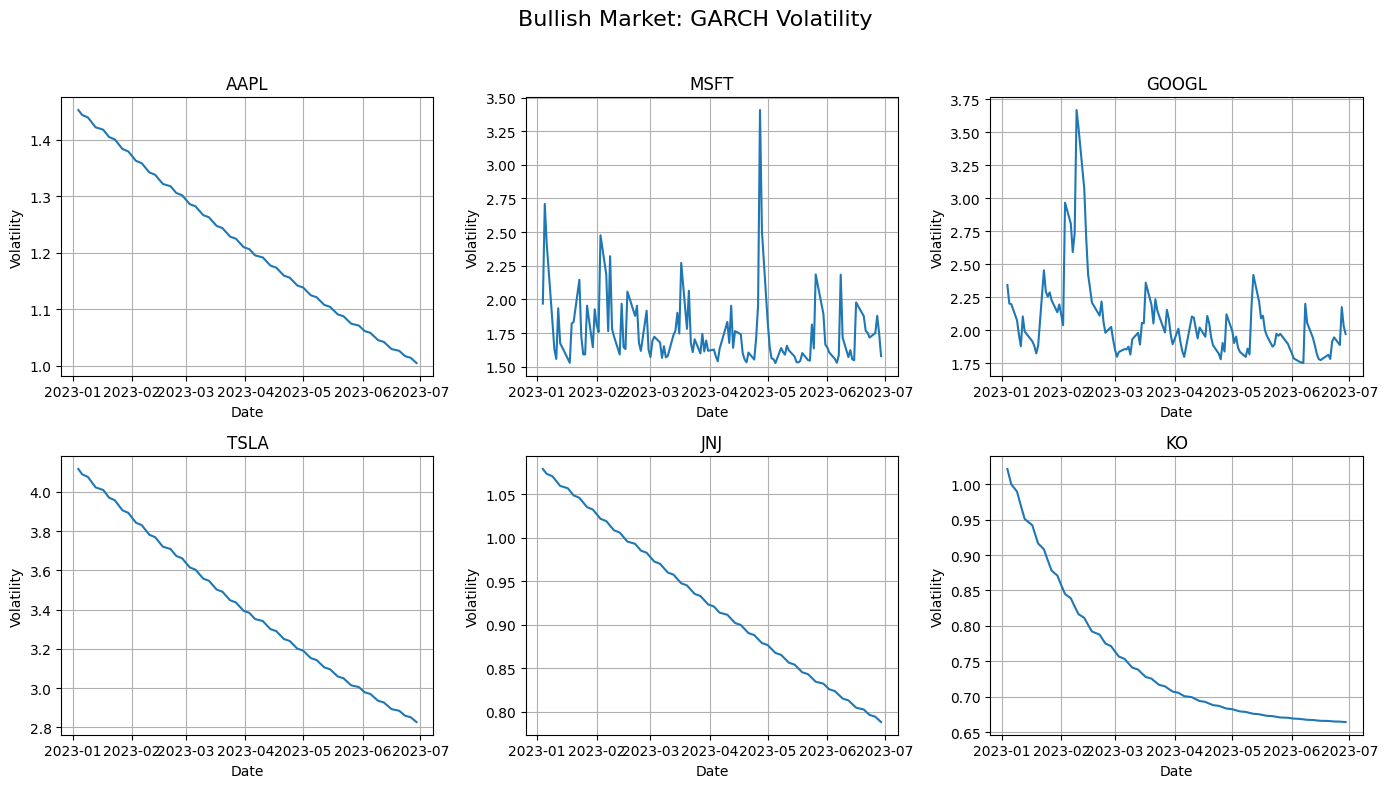

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Stock   Beta  Avg_GARCH_Volatility
   KO 0.3352                0.7489
  JNJ 0.3777                0.9260
 AAPL 1.1256                1.2151
 MSFT 1.2505                1.7616
GOOGL 1.3986                2.0656
 TSLA 2.1143                3.4168

✅ Safest Option in BULLISH Market: KO (Beta=0.3352, Vol=0.7489)


=== BEARISH MARKET ANALYSIS (2022-06-01 to 2022-12-31) ===




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


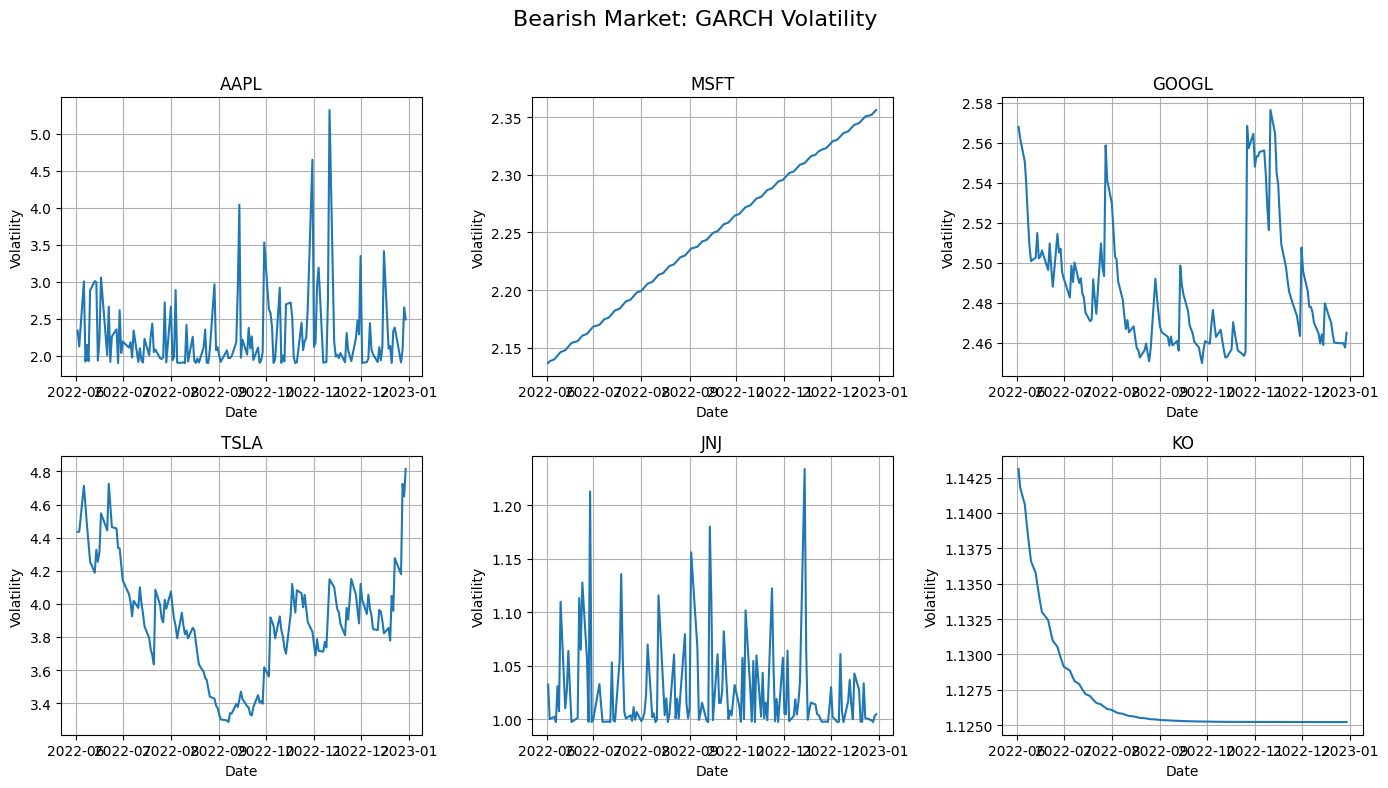

Stock   Beta  Avg_GARCH_Volatility
  JNJ 0.3402                1.0264
   KO 0.5316                1.1269
 MSFT 1.2950                2.2486
 AAPL 1.3067                2.2676
GOOGL 1.3696                2.4880
 TSLA 1.5392                3.8997

✅ Safest Option in BEARISH Market: JNJ (Beta=0.3402, Vol=1.0264)



In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm

# Define market periods
bullish_period = ('2023-01-01', '2023-06-30')
bearish_period = ('2022-06-01', '2022-12-31')

# Stocks and index
stocks = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'JNJ', 'KO']
index_symbol = '^GSPC'

def analyze_stocks(period, label):
    start, end = period
    print(f"\n=== {label.upper()} MARKET ANALYSIS ({start} to {end}) ===\n")

    results = []
    index_data = yf.download(index_symbol, start=start, end=end, auto_adjust=False)['Adj Close']
    index_returns = np.log(index_data / index_data.shift(1)).dropna()

    plt.figure(figsize=(14, 8))
    plt.suptitle(f"{label.capitalize()} Market: GARCH Volatility", fontsize=16)

    for i, stock in enumerate(stocks):
        try:
            stock_data = yf.download(stock, start=start, end=end, auto_adjust=False)['Adj Close']
            stock_returns = np.log(stock_data / stock_data.shift(1)).dropna()
            combined = pd.concat([stock_returns, index_returns], axis=1).dropna()
            combined.columns = ['Stock', 'Market']

            # Beta calculation
            X = sm.add_constant(combined['Market'])
            model = sm.OLS(combined['Stock'], X).fit()
            beta = model.params['Market']

            # GARCH volatility
            am = arch_model(combined['Stock'] * 100, vol='GARCH', p=1, q=1)
            res = am.fit(disp='off')
            avg_vol = np.mean(res.conditional_volatility)

            # Plot GARCH
            plt.subplot(2, 3, i + 1)
            plt.plot(res.conditional_volatility, label=stock)
            plt.title(f"{stock}")
            plt.grid(True)
            plt.xlabel("Date")
            plt.ylabel("Volatility")

            results.append({
                'Stock': stock,
                'Beta': round(beta, 4),
                'Avg_GARCH_Volatility': round(avg_vol, 4)
            })

        except Exception as e:
            print(f"Error processing {stock}: {e}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Results Table
    df = pd.DataFrame(results)
    df = df.sort_values(by=['Avg_GARCH_Volatility', 'Beta'])
    print(df.to_string(index=False))

    safest = df.iloc[0]
    print(f"\n✅ Safest Option in {label.upper()} Market: {safest['Stock']} (Beta={safest['Beta']}, Vol={safest['Avg_GARCH_Volatility']})\n")
    return df

# Run analysis
bullish_df = analyze_stocks(bullish_period, 'bullish')
bearish_df = analyze_stocks(bearish_period, 'bearish')

[*********************100%***********************]  1 of 1 completed


=== BULLISH MARKET ANALYSIS (2023-03-01 to 2023-07-31) ===




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


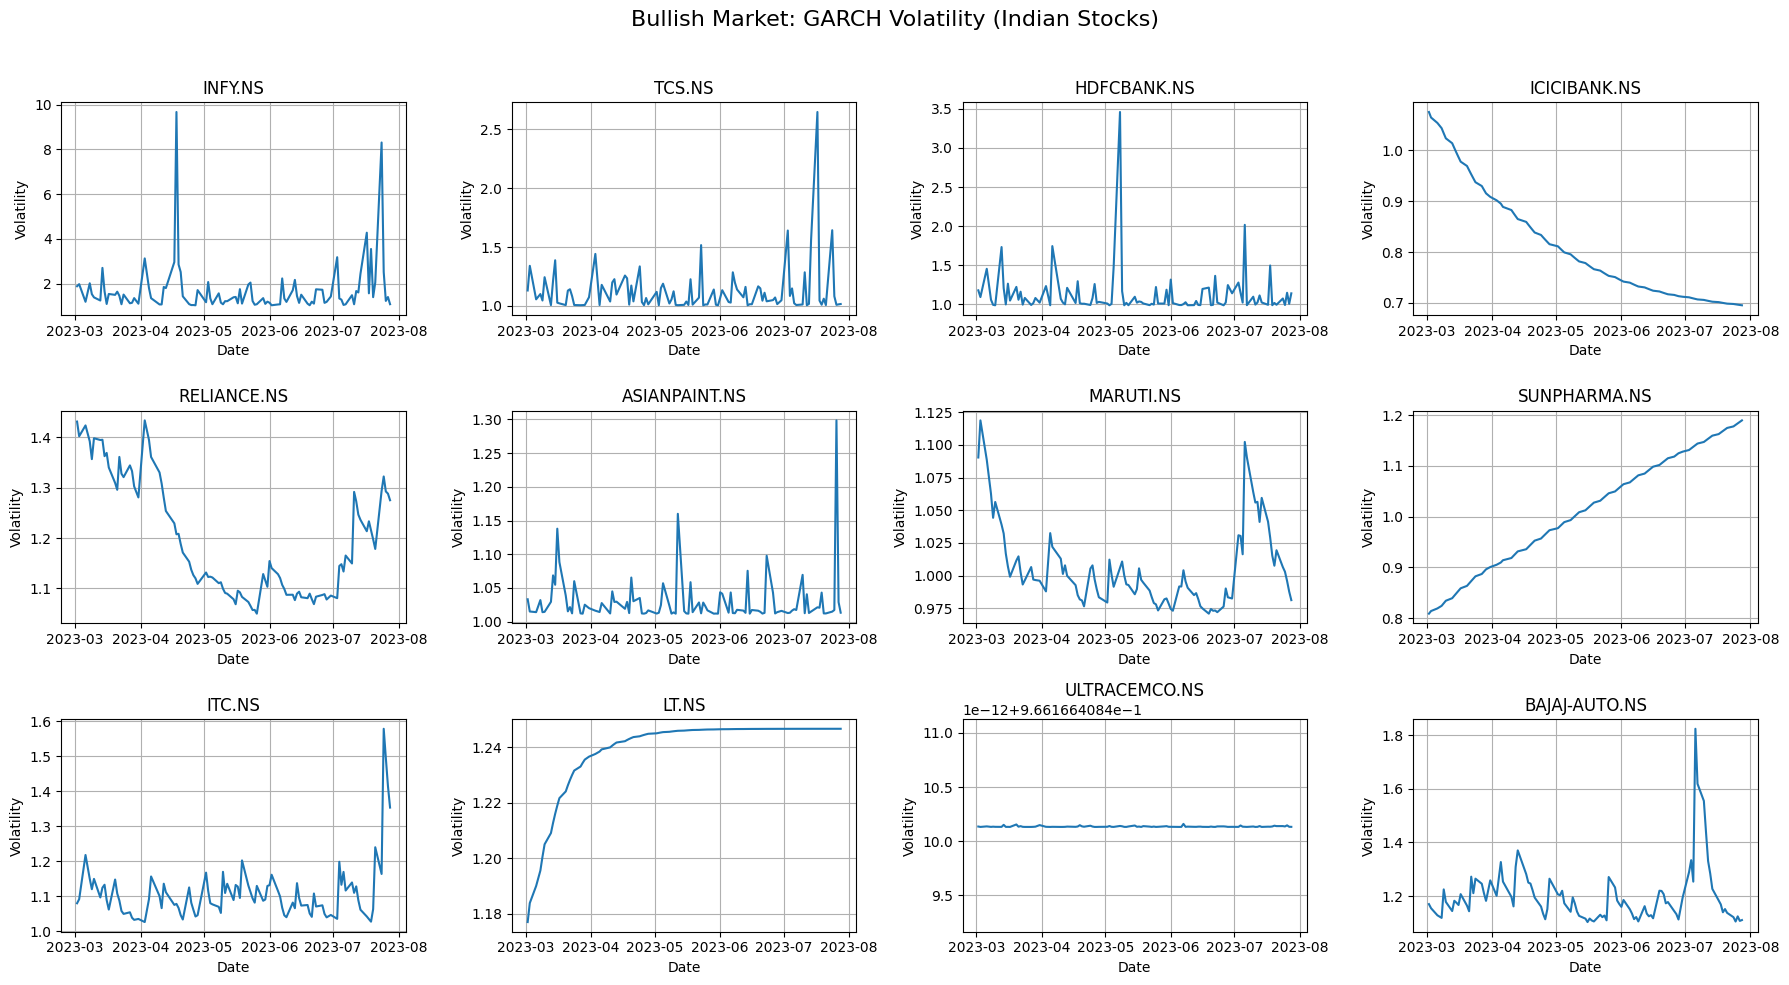

[*********************100%***********************]  1 of 1 completed

        Stock   Beta  Avg_GARCH_Volatility
 ICICIBANK.NS 0.8406                0.8064
ULTRACEMCO.NS 0.5736                0.9662
    MARUTI.NS 0.4506                1.0059
 SUNPHARMA.NS 0.2947                1.0168
ASIANPAINT.NS 0.2618                1.0298
       ITC.NS 0.7836                1.1102
  HDFCBANK.NS 1.2456                1.1221
       TCS.NS 0.9347                1.1235
  RELIANCE.NS 1.5036                1.1960
BAJAJ-AUTO.NS 0.7050                1.1987
        LT.NS 0.6724                1.2395
      INFY.NS 1.6759                1.6901

✅ Safest Option in BULLISH Market: ICICIBANK.NS (Beta=0.8406, Vol=0.8064)


=== BEARISH MARKET ANALYSIS (2022-09-01 to 2022-12-31) ===




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


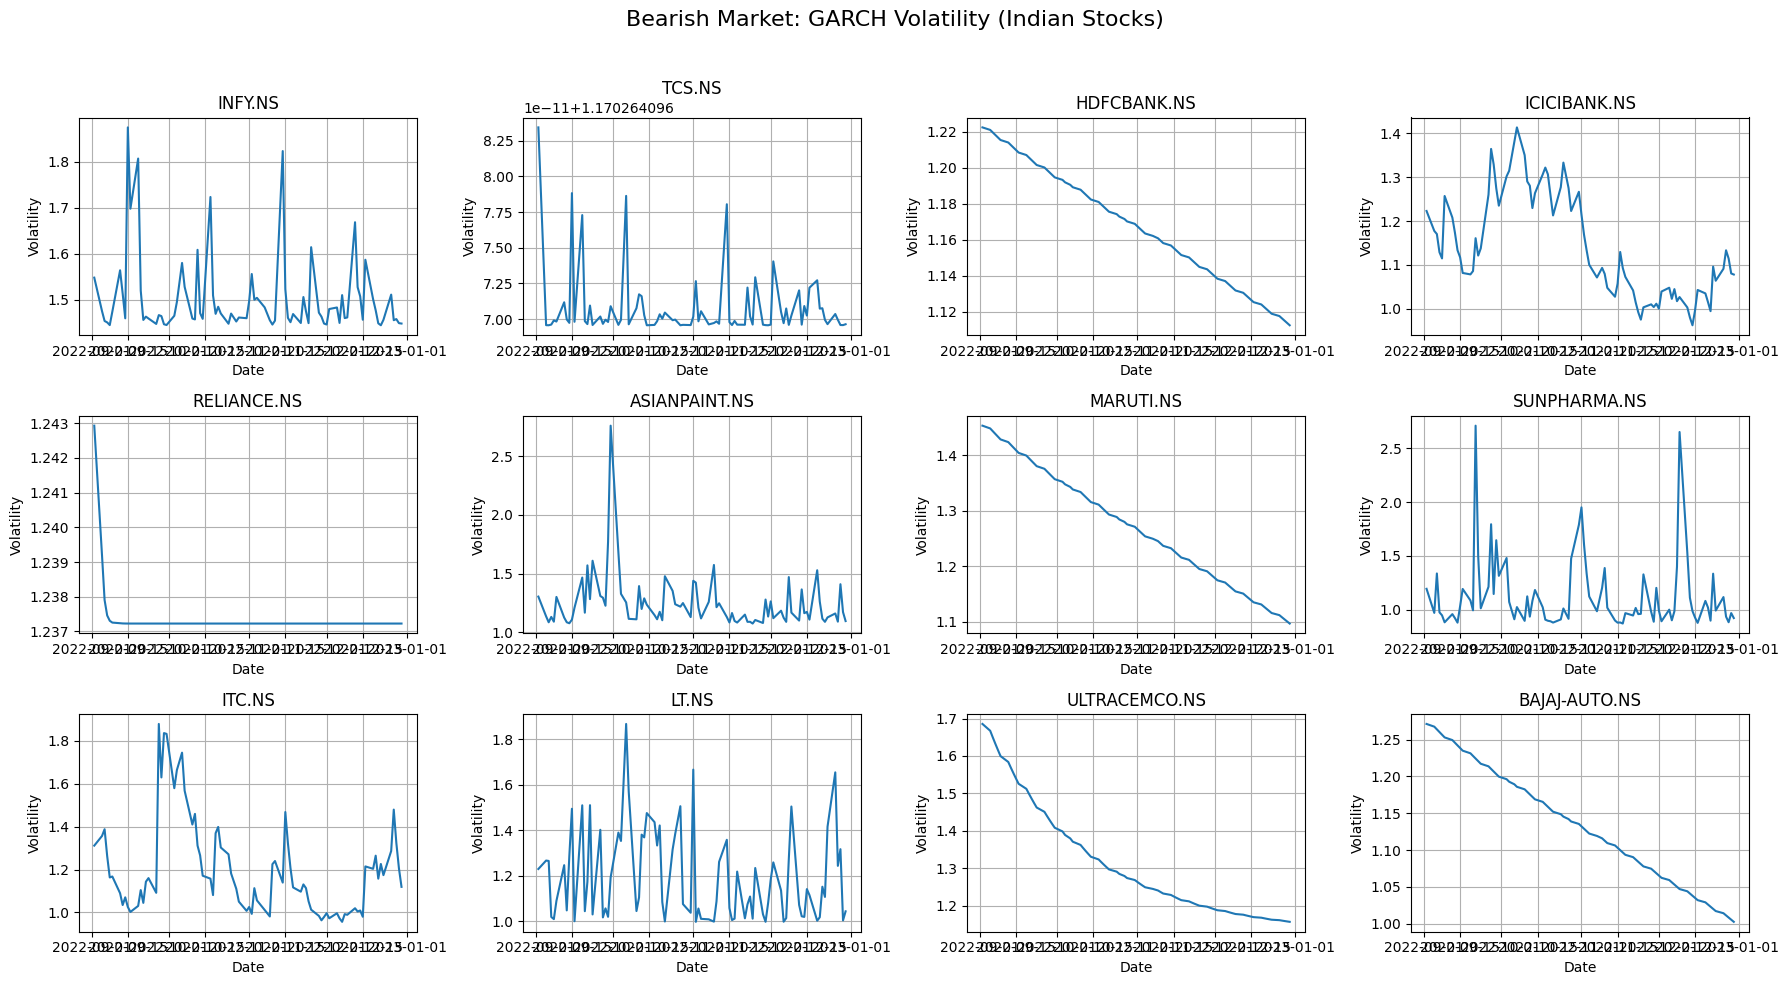

        Stock   Beta  Avg_GARCH_Volatility
 SUNPHARMA.NS 0.4088                1.1302
BAJAJ-AUTO.NS 0.8656                1.1316
 ICICIBANK.NS 0.9622                1.1407
  HDFCBANK.NS 1.1625                1.1666
       TCS.NS 0.8844                1.1703
        LT.NS 1.0514                1.1938
       ITC.NS 0.8304                1.1987
  RELIANCE.NS 1.1060                1.2373
ASIANPAINT.NS 0.3966                1.2443
    MARUTI.NS 0.8566                1.2666
ULTRACEMCO.NS 1.0092                1.3121
      INFY.NS 1.2140                1.5010

✅ Safest Option in BEARISH Market: SUNPHARMA.NS (Beta=0.4088, Vol=1.1302)



In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm

# Periods (can be fine-tuned)
bullish_period = ('2023-03-01', '2023-07-31')
bearish_period = ('2022-09-01', '2022-12-31')

# Indian stocks list
stocks = [
    "INFY.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS", "RELIANCE.NS",
    "ASIANPAINT.NS", "MARUTI.NS", "SUNPHARMA.NS", "ITC.NS", "LT.NS",
    "ULTRACEMCO.NS", "BAJAJ-AUTO.NS", "TITAN.NS", "WIPRO.NS", "ZOMATO.NS"
]
index_symbol = "^NSEI"  # Nifty 50

def analyze_stocks(period, label):
    start, end = period
    print(f"\n=== {label.upper()} MARKET ANALYSIS ({start} to {end}) ===\n")

    results = []
    index_data = yf.download(index_symbol, start=start, end=end, auto_adjust=False)['Adj Close']
    index_returns = np.log(index_data / index_data.shift(1)).dropna()

    plt.figure(figsize=(18, 10))
    plt.suptitle(f"{label.capitalize()} Market: GARCH Volatility (Indian Stocks)", fontsize=16)

    for i, stock in enumerate(stocks[:12]):  # Plot only 12 to avoid clutter
        try:
            stock_data = yf.download(stock, start=start, end=end, auto_adjust=False)['Adj Close']
            stock_returns = np.log(stock_data / stock_data.shift(1)).dropna()
            combined = pd.concat([stock_returns, index_returns], axis=1).dropna()
            combined.columns = ['Stock', 'Market']

            # Beta calculation
            X = sm.add_constant(combined['Market'])
            model = sm.OLS(combined['Stock'], X).fit()
            beta = model.params['Market']

            # GARCH volatility
            am = arch_model(combined['Stock'] * 100, vol='GARCH', p=1, q=1)
            res = am.fit(disp='off')
            avg_vol = np.mean(res.conditional_volatility)

            # Plot GARCH
            plt.subplot(3, 4, i + 1)
            plt.plot(res.conditional_volatility, label=stock)
            plt.title(f"{stock}")
            plt.grid(True)
            plt.xlabel("Date")
            plt.ylabel("Volatility")

            results.append({
                'Stock': stock,
                'Beta': round(beta, 4),
                'Avg_GARCH_Volatility': round(avg_vol, 4)
            })

        except Exception as e:
            print(f"Error processing {stock}: {e}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    df = pd.DataFrame(results)
    df = df.sort_values(by=['Avg_GARCH_Volatility', 'Beta'])
    print(df.to_string(index=False))

    safest = df.iloc[0]
    print(f"\n✅ Safest Option in {label.upper()} Market: {safest['Stock']} (Beta={safest['Beta']}, Vol={safest['Avg_GARCH_Volatility']})\n")
    return df

# Run both periods
bullish_df = analyze_stocks(bullish_period, 'bullish')
bearish_df = analyze_stocks(bearish_period, 'bearish')

In [9]:
def recommend_stocks(
    stocks, index_symbol, start_date, end_date,
    top_n=3, risk_weights=(0.6, 0.4)
):
    import yfinance as yf
    import pandas as pd
    import numpy as np
    from arch import arch_model
    import statsmodels.api as sm

    vol_weight, beta_weight = risk_weights
    results = []

    # Get index data
    index_data = yf.download(index_symbol, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
    index_returns = np.log(index_data / index_data.shift(1)).dropna()

    for stock in stocks:
        try:
            stock_data = yf.download(stock, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
            stock_returns = np.log(stock_data / stock_data.shift(1)).dropna()
            combined = pd.concat([stock_returns, index_returns], axis=1).dropna()
            combined.columns = ['Stock', 'Market']

            # Beta
            X = sm.add_constant(combined['Market'])
            model = sm.OLS(combined['Stock'], X).fit()
            beta = model.params['Market']

            # GARCH volatility
            am = arch_model(combined['Stock'] * 100, vol='GARCH', p=1, q=1)
            res = am.fit(disp='off')
            avg_vol = np.mean(res.conditional_volatility)

            # Compute risk score
            risk_score = vol_weight * avg_vol + beta_weight * beta

            results.append({
                'Stock': stock,
                'Beta': round(beta, 4),
                'Avg_GARCH_Volatility': round(avg_vol, 4),
                'Risk_Score': round(risk_score, 4)
            })

        except Exception as e:
            print(f"Error processing {stock}: {e}")

    df = pd.DataFrame(results)
    df = df.sort_values(by='Risk_Score')
    print(df.to_string(index=False))

    recommended = df.head(top_n)
    print(f"\n✅ Top {top_n} Safest Stocks (Lowest Risk Score):")
    for _, row in recommended.iterrows():
        print(f"{row['Stock']} → Risk Score: {row['Risk_Score']}, Beta: {row['Beta']}, Vol: {row['Avg_GARCH_Volatility']}")

    return recommended

In [10]:
stocks = [
    "INFY.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS", "RELIANCE.NS",
    "ASIANPAINT.NS", "MARUTI.NS", "SUNPHARMA.NS", "ITC.NS", "LT.NS",
    "ULTRACEMCO.NS", "BAJAJ-AUTO.NS", "TITAN.NS", "WIPRO.NS", "ZOMATO.NS"
]

recommend_stocks(
    stocks=stocks,
    index_symbol="^NSEI",
    start_date="2023-01-01",
    end_date="2023-06-30",
    top_n=5,
    risk_weights=(0.6, 0.4)
)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

        Stock   Beta  Avg_GARCH_Volatility  Risk_Score
 SUNPHARMA.NS 0.3288                0.9459      0.6991
    MARUTI.NS 0.4261                0.9302      0.7286
ASIANPAINT.NS 0.4218                1.0844      0.8194
ULTRACEMCO.NS 0.5033                1.0562      0.8350
       ITC.NS 0.4793                1.0932      0.8476
BAJAJ-AUTO.NS 0.4164                1.2876      0.9391
 ICICIBANK.NS 0.9933                0.9137      0.9455
     TITAN.NS 0.7233                1.1589      0.9846
     WIPRO.NS 0.8984                1.0439      0.9857
       TCS.NS 0.9335                1.0525      1.0049
        LT.NS 0.7232                1.1984      1.0083
  HDFCBANK.NS 1.2220                1.1247      1.1636
  RELIANCE.NS 1.3811                1.0926      1.2080
      INFY.NS 1.3211                1.3966      1.3664
    ZOMATO.NS 1.2712                2.4303      1.9667

✅ Top 5 Safest Stocks (Lowest Risk Score):
SUNPHARMA.NS → Risk Score: 0.6991, Beta: 0.3288, Vol: 0.9459
MARUTI.NS → Ris

,Stock,Beta,Avg_GARCH_Volatility,Risk_Score
7,SUNPHARMA.NS,0.3288,0.9459,0.6991
6,MARUTI.NS,0.4261,0.9302,0.7286
5,ASIANPAINT.NS,0.4218,1.0844,0.8194
10,ULTRACEMCO.NS,0.5033,1.0562,0.8350
8,ITC.NS,0.4793,1.0932,0.8476
